# BaarleNet [Part 6 - Scale up Width].ipynb

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

def extract_weights_to_numpy(model, layer_indices=None, output_file=None):
    """
    Extract PyTorch model weights and biases to NumPy arrays with copy-paste ready code.
    
    Args:
        model: PyTorch model
        layer_indices: List of layer indices to extract (if None, extracts all layers with weights)
        output_file: Optional file path to save the output code
    
    Returns:
        String containing the NumPy array definitions ready to copy-paste
    """
    
    lines = []
    lines.append("import numpy as np\n")
    
    # Auto-detect layers if not specified
    if layer_indices is None:
        layer_indices = []
        for i, layer in enumerate(model.model):
            if hasattr(layer, 'weight'):
                layer_indices.append(i)
    
    # Extract weights and biases
    weight_counter = 1
    for idx in layer_indices:
        layer = model.model[idx]
        
        if hasattr(layer, 'weight'):
            # Extract weight
            weight_np = layer.weight.detach().numpy()
            weight_repr = np.array2string(weight_np, 
                                        separator=', ', 
                                        formatter={'float_kind': lambda x: f"{x:g}"})
            lines.append(f"w{weight_counter} = np.array({weight_repr}, dtype=np.float32)")
            
            # Extract bias if it exists
            if hasattr(layer, 'bias') and layer.bias is not None:
                bias_np = layer.bias.detach().numpy()
                bias_repr = np.array2string(bias_np, 
                                          separator=', ', 
                                          formatter={'float_kind': lambda x: f"{x:g}"})
                lines.append(f"b{weight_counter} = np.array({bias_repr}, dtype=np.float32)")
            
            weight_counter += 1
    
    output = '\n'.join(lines)
    
    # Save to file if specified
    if output_file:
        with open(output_file, 'w') as f:
            f.write(output)
        print(f"Weights saved to {output_file}")
    
    # Print to console
    print(output)
    return output

def extract_specific_layers(model, layer_specs):
    """
    Extract specific layers with custom naming.
    
    Args:
        model: PyTorch model
        layer_specs: List of tuples (layer_index, weight_name, bias_name)
                    e.g., [(0, 'w1', 'b1'), (2, 'w2', 'b2')]
    
    Returns:
        String containing the NumPy array definitions
    """
    
    lines = []
    lines.append("import numpy as np\n")
    
    for layer_idx, weight_name, bias_name in layer_specs:
        layer = model.model[layer_idx]
        
        if hasattr(layer, 'weight'):
            # Extract weight
            weight_np = layer.weight.detach().numpy()
            weight_repr = np.array2string(weight_np, 
                                        separator=', ', 
                                        formatter={'float_kind': lambda x: f"{x:g}"})
            lines.append(f"{weight_name} = np.array({weight_repr}, dtype=np.float32)")
            
            # Extract bias if it exists and bias_name is provided
            if bias_name and hasattr(layer, 'bias') and layer.bias is not None:
                bias_np = layer.bias.detach().numpy()
                bias_repr = np.array2string(bias_np, 
                                          separator=', ', 
                                          formatter={'float_kind': lambda x: f"{x:g}"})
                lines.append(f"{bias_name} = np.array({bias_repr}, dtype=np.float32)")
    
    output = '\n'.join(lines)
    print(output)
    return output

In [3]:
def get_second_layer_boundaries(model, extent=1):
    """
    Analytically solve for second layer ReLU boundaries
    Returns list of line segments for each second layer neuron
    """
    
    # Get layer weights and biases
    W1 = model.model[0].weight.detach().numpy()  # Shape: (2, 2)
    b1 = model.model[0].bias.detach().numpy()    # Shape: (2,)
    W2 = model.model[2].weight.detach().numpy()  # Shape: (2, 2) 
    b2 = model.model[2].bias.detach().numpy()    # Shape: (2,)
    
    # First, get the first layer ReLU boundaries
    first_layer_boundaries = []
    for i in range(2):
        boundary = get_relu_joint(W1[i,0], W1[i,1], b1[i], extent)
        first_layer_boundaries.append(boundary)
    
    # Define the regions created by first layer boundaries
    # Each region is defined by which first layer neurons are active
    regions = [
        (False, False),  # Both neurons off
        (True, False),   # First neuron on, second off
        (False, True),   # First neuron off, second on  
        (True, True)     # Both neurons on
    ]
    
    second_layer_boundaries = []
    
    # For each second layer neuron
    for neuron_idx in range(2):
        neuron_boundaries = []
        
        # For each region defined by first layer
        for region_mask in regions:
            # In this region, the second layer pre-activation is:
            # h2_pre = W2[neuron_idx, 0] * (W1[0,:] * x + b1[0]) * region_mask[0] + 
            #          W2[neuron_idx, 1] * (W1[1,:] * x + b1[1]) * region_mask[1] + 
            #          b2[neuron_idx]
            
            # Collect active terms
            active_weight = np.zeros(2)  # Coefficients for [x, y]
            active_bias = b2[neuron_idx]
            
            for i in range(2):
                if region_mask[i]:  # If this first layer neuron is active
                    active_weight += W2[neuron_idx, i] * W1[i, :]
                    active_bias += W2[neuron_idx, i] * b1[i]
            
            # Now solve: active_weight[0] * x + active_weight[1] * y + active_bias = 0
            boundary = get_relu_joint(active_weight[0], active_weight[1], active_bias, extent)
            
            if boundary:
                # Check if this boundary segment is actually within the region
                # We need to verify that the boundary points satisfy the region constraints
                valid_segments = []
                
                for seg_start, seg_end in zip(boundary[:-1], boundary[1:]):
                    # Check if segment is within the region defined by first layer
                    # Sample a point in the middle of the segment
                    mid_point = [(seg_start[0] + seg_end[0])/2, (seg_start[1] + seg_end[1])/2]
                    
                    # Check if this point satisfies the region constraints
                    point_in_region = True
                    for i in range(2):
                        first_layer_activation = W1[i,0] * mid_point[0] + W1[i,1] * mid_point[1] + b1[i]
                        is_active = first_layer_activation > 0
                        if is_active != region_mask[i]:
                            point_in_region = False
                            break
                    
                    if point_in_region:
                        valid_segments.append([seg_start, seg_end])
                
                neuron_boundaries.extend(valid_segments)
        
        second_layer_boundaries.append(neuron_boundaries)
    
    return second_layer_boundaries

def plot_second_layer_boundaries_analytical(ax, model):
    """Plot analytically computed second layer boundaries"""
    
    boundaries = get_second_layer_boundaries(model)
    
    colors = ['red', 'blue']
    for neuron_idx, neuron_boundaries in enumerate(boundaries):
        for segment in neuron_boundaries:
            if len(segment) == 2:  # Valid line segment
                seg_denorm = denorm(np.array(segment))
                ax.plot([seg_denorm[0][0], seg_denorm[1][0]], 
                       [seg_denorm[0][1], seg_denorm[1][1]], 
                       color=colors[neuron_idx], linewidth=2, alpha=0.8,
                       linestyle='dashed', label=f'Layer 2 Neuron {neuron_idx}')

# Simpler version that focuses on the boundary intersections
def get_second_layer_boundaries_simple(model, extent=1):
    """
    Simplified approach: compute boundary in each quadrant defined by first layer
    """
    W1 = model.model[0].weight.detach().numpy()
    b1 = model.model[0].bias.detach().numpy()
    W2 = model.model[2].weight.detach().numpy()
    b2 = model.model[2].bias.detach().numpy()
    
    boundaries = []
    
    # For each second layer neuron
    for neuron_idx in range(2):
        neuron_boundaries = []
        
        # Sample points in a grid and find where the second layer neuron crosses zero
        # But do it analytically by solving the piecewise linear equation
        
        # The key insight: in each region, the equation is linear
        # Region 1: both first layer neurons off
        # h2 = b2[neuron_idx]
        # This gives no boundary unless b2[neuron_idx] = 0
        
        # Region 2: first neuron on, second off  
        # h2 = W2[neuron_idx,0] * (W1[0,0]*x + W1[0,1]*y + b1[0]) + b2[neuron_idx]
        # Set to 0 and solve for the line
        if True:  # Always try this region
            w_eff = W2[neuron_idx, 0] * W1[0, :]
            b_eff = W2[neuron_idx, 0] * b1[0] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        # Region 3: first neuron off, second on
        if True:
            w_eff = W2[neuron_idx, 1] * W1[1, :]
            b_eff = W2[neuron_idx, 1] * b1[1] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        # Region 4: both neurons on
        if True:
            w_eff = W2[neuron_idx, 0] * W1[0, :] + W2[neuron_idx, 1] * W1[1, :]
            b_eff = W2[neuron_idx, 0] * b1[0] + W2[neuron_idx, 1] * b1[1] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        boundaries.append(neuron_boundaries)
    
    return boundaries

# Usage:
def plot_all_boundaries(ax, model):
    """Plot both first and second layer boundaries"""
    
    # First layer (solid lines)
    for neuron_idx in range(2):
        w1 = model.model[0].weight[neuron_idx, 0].item()
        w2 = model.model[0].weight[neuron_idx, 1].item()
        b = model.model[0].bias[neuron_idx].item()
        
        joint = get_relu_joint(w1, w2, b, extent=1)
        if joint:
            joint_denorm = denorm(np.array(joint))
            ax.plot([joint_denorm[0][0], joint_denorm[1][0]], 
                   [joint_denorm[0][1], joint_denorm[1][1]], 
                   color=f'C{neuron_idx}', linewidth=2, alpha=0.8,
                   label=f'Layer 1 Neuron {neuron_idx}')
    
    # Second layer (dashed lines)
    plot_second_layer_boundaries_analytical(ax, model)

In [4]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

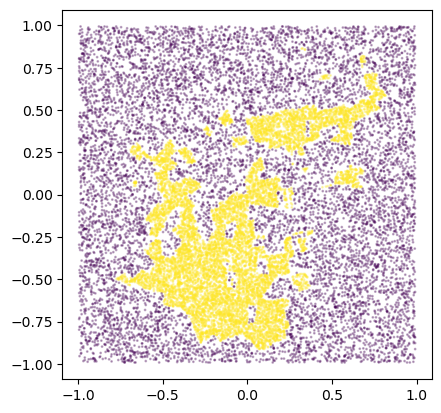

In [5]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');

In [6]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

## 3 Neurons

In [2]:
# num_neurons=3
# accuracies=[]
# for random_seed in range(1000):
#     torch.manual_seed(random_seed)  
    
#     X_tensor = torch.FloatTensor(X)
#     y_tensor = torch.tensor(y)
    
#     # Initialize model and optimizer
#     model = BaarleNet([num_neurons])
#     criterion = nn.CrossEntropyLoss()
#     # optimizer = optim.SGD(model.parameters(), lr=0.25)
#     optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005
    
#     num_epochs = 10000
#     for epoch in range(num_epochs):
#         # Batch
#         #outputs = model(X_tensor)
#         #loss = criterion(outputs, y_tensor)
    
#         #Stochastic
#         outputs = model(torch.tensor(X[epoch%len(y)]).float())
#         loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
#         #Worth trying minibatch?
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
    
#         # if epoch==307: break #Stop early here so weights don't get updated before we poke around
        
#         optimizer.step()

#     outputs_batch = model(X_tensor)
#     accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
#     if accuracy>0.85:
#         print(f'Seed [{random_seed}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
#     accuracies.append(accuracies)

In [7]:
random_seed=520 #Random seed of 3 makes for a nice "fold down the edges" deal, wait that's for 2x2
num_neurons=3

torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

num_epochs = 10000
for epoch in range(num_epochs):
    # Batch
    #outputs = model(X_tensor)
    #loss = criterion(outputs, y_tensor)

    #Stochastic
    outputs = model(torch.tensor(X[epoch%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [400/10000], Loss: 0.9878, Accuracy: 0.6829
Epoch [800/10000], Loss: 0.3189, Accuracy: 0.6692
Epoch [1200/10000], Loss: 0.2280, Accuracy: 0.7440
Epoch [1600/10000], Loss: 0.1514, Accuracy: 0.7631
Epoch [2000/10000], Loss: 0.7202, Accuracy: 0.8043
Epoch [2400/10000], Loss: 0.5516, Accuracy: 0.7817
Epoch [2800/10000], Loss: 1.9298, Accuracy: 0.8268
Epoch [3200/10000], Loss: 0.0655, Accuracy: 0.7980
Epoch [3600/10000], Loss: 0.5307, Accuracy: 0.8408
Epoch [4000/10000], Loss: 0.1856, Accuracy: 0.8349
Epoch [4400/10000], Loss: 0.6457, Accuracy: 0.8405
Epoch [4800/10000], Loss: 0.0287, Accuracy: 0.7967
Epoch [5200/10000], Loss: 0.0013, Accuracy: 0.8205
Epoch [5600/10000], Loss: 0.8047, Accuracy: 0.8296
Epoch [6000/10000], Loss: 0.1780, Accuracy: 0.8149
Epoch [6400/10000], Loss: 0.1483, Accuracy: 0.8449
Epoch [6800/10000], Loss: 0.1027, Accuracy: 0.8306
Epoch [7200/10000], Loss: 0.7298, Accuracy: 0.8270
Epoch [7600/10000], Loss: 0.0000, Accuracy: 0.8367
Epoch [8000/10000], Loss: 0.2696,

In [9]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

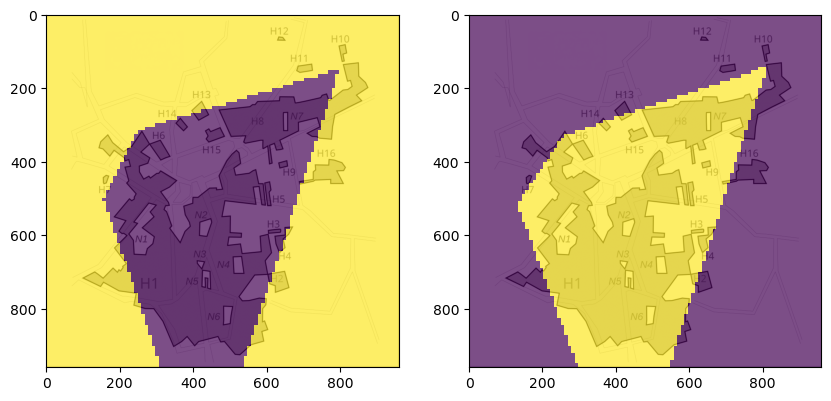

In [10]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [11]:
torch.save(model.state_dict(), '../models/3_1.pth')

In [32]:
_=extract_weights_to_numpy(model)

import numpy as np

w1 = np.array([[-2.00458, 2.24611],
 [-2.56046, -1.21349],
 [-1.94774, 0.716835]], dtype=np.float32)
b1 = np.array([0.00728259, -1.38003, 1.77056], dtype=np.float32)
w2 = np.array([[2.46867, 3.78735, -1.90977],
 [-2.55351, -2.95687, 1.74294]], dtype=np.float32)
b2 = np.array([1.41342, -1.23457], dtype=np.float32)


In [33]:
model.model[0].weight

Parameter containing:
tensor([[-2.0046,  2.2461],
        [-2.5605, -1.2135],
        [-1.9477,  0.7168]], requires_grad=True)

In [34]:
model.model[2].weight

Parameter containing:
tensor([[ 2.4687,  3.7873, -1.9098],
        [-2.5535, -2.9569,  1.7429]], requires_grad=True)

## 4 Neurons


In [40]:
num_neurons=4
accuracies=[]
for random_seed in range(100):
    torch.manual_seed(random_seed)  
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Initialize model and optimizer
    model = BaarleNet([num_neurons])
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.25)
    optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005
    
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Batch
        #outputs = model(X_tensor)
        #loss = criterion(outputs, y_tensor)
    
        #Stochastic
        outputs = model(torch.tensor(X[epoch%len(y)]).float())
        loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
        #Worth trying minibatch?
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
    
        # if epoch==307: break #Stop early here so weights don't get updated before we poke around
        
        optimizer.step()

    outputs_batch = model(X_tensor)
    accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
    if accuracy>0.85:
        print(f'Seed [{random_seed}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    accuracies.append(accuracy)

Seed [0], Loss: 0.1014, Accuracy: 0.8629
Seed [1], Loss: 0.2898, Accuracy: 0.8560
Seed [2], Loss: 0.1051, Accuracy: 0.8626
Seed [6], Loss: 0.0993, Accuracy: 0.8530
Seed [7], Loss: 0.1762, Accuracy: 0.8542
Seed [10], Loss: 0.2558, Accuracy: 0.8591
Seed [23], Loss: 0.0995, Accuracy: 0.8636
Seed [24], Loss: 0.0860, Accuracy: 0.8549
Seed [35], Loss: 0.1029, Accuracy: 0.8560
Seed [36], Loss: 0.1134, Accuracy: 0.8645
Seed [39], Loss: 0.1008, Accuracy: 0.8638
Seed [40], Loss: 0.1014, Accuracy: 0.8500
Seed [45], Loss: 0.1771, Accuracy: 0.8569
Seed [47], Loss: 0.2784, Accuracy: 0.8569
Seed [49], Loss: 0.0976, Accuracy: 0.8621
Seed [56], Loss: 0.1010, Accuracy: 0.8631
Seed [57], Loss: 0.0996, Accuracy: 0.8611
Seed [58], Loss: 0.3320, Accuracy: 0.8559
Seed [64], Loss: 0.1044, Accuracy: 0.8629
Seed [65], Loss: 0.0864, Accuracy: 0.8625
Seed [72], Loss: 0.2670, Accuracy: 0.8595
Seed [77], Loss: 0.1030, Accuracy: 0.8626
Seed [86], Loss: 0.2761, Accuracy: 0.8579
Seed [87], Loss: 0.0965, Accuracy: 0.86

In [41]:
np.argmax(accuracies)

36

In [42]:
accuracies[36]

0.86445

In [48]:
random_seed=36 #Random seed of 3 makes for a nice "fold down the edges" deal, wait that's for 2x2
num_neurons=4

torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

num_epochs = 10000
for epoch in range(num_epochs):
    # Batch
    #outputs = model(X_tensor)
    #loss = criterion(outputs, y_tensor)

    #Stochastic
    outputs = model(torch.tensor(X[epoch%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [400/10000], Loss: 1.0241, Accuracy: 0.6391
Epoch [800/10000], Loss: 0.4624, Accuracy: 0.6418
Epoch [1200/10000], Loss: 0.9557, Accuracy: 0.7266
Epoch [1600/10000], Loss: 0.4489, Accuracy: 0.7615
Epoch [2000/10000], Loss: 0.6871, Accuracy: 0.8203
Epoch [2400/10000], Loss: 1.7292, Accuracy: 0.8153
Epoch [2800/10000], Loss: 2.2713, Accuracy: 0.7666
Epoch [3200/10000], Loss: 0.0017, Accuracy: 0.8176
Epoch [3600/10000], Loss: 0.0351, Accuracy: 0.8249
Epoch [4000/10000], Loss: 0.2799, Accuracy: 0.8387
Epoch [4400/10000], Loss: 0.0002, Accuracy: 0.8047
Epoch [4800/10000], Loss: 0.3671, Accuracy: 0.8302
Epoch [5200/10000], Loss: 0.0000, Accuracy: 0.8470
Epoch [5600/10000], Loss: 0.3085, Accuracy: 0.8136
Epoch [6000/10000], Loss: 0.2255, Accuracy: 0.8199
Epoch [6400/10000], Loss: 0.0499, Accuracy: 0.8133
Epoch [6800/10000], Loss: 0.0843, Accuracy: 0.8619
Epoch [7200/10000], Loss: 0.2446, Accuracy: 0.8507
Epoch [7600/10000], Loss: 0.8312, Accuracy: 0.8470
Epoch [8000/10000], Loss: 1.8316,

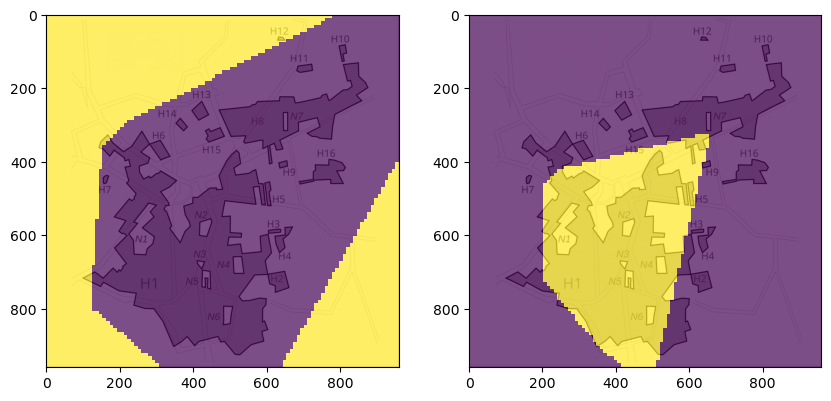

In [49]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [50]:
_=extract_weights_to_numpy(model)

import numpy as np

w1 = np.array([[-1.8741, 2.12215],
 [-2.39381, -1.24014],
 [-0.940185, 1.40271],
 [2.04548, 0.489156]], dtype=np.float32)
b1 = np.array([-0.00892048, -1.32954, 1.71349, 0.940607], dtype=np.float32)
w2 = np.array([[2.56674, 2.26244, -1.40175, 0.737865],
 [-2.58904, -3.0681, 1.08007, -1.32219]], dtype=np.float32)
b2 = np.array([-0.852075, 0.492386], dtype=np.float32)


## 8 Neurons

In [18]:
num_neurons=8
accuracies=[]
for random_seed in range(100):
    torch.manual_seed(random_seed)  
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Initialize model and optimizer
    model = BaarleNet([num_neurons])
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.25)
    optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005
    
    num_epochs = 15000
    for epoch in range(num_epochs):
        # Batch
        #outputs = model(X_tensor)
        #loss = criterion(outputs, y_tensor)
    
        #Stochastic
        outputs = model(torch.tensor(X[epoch%len(y)]).float())
        loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
        #Worth trying minibatch?
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
    
        # if epoch==307: break #Stop early here so weights don't get updated before we poke around
        
        optimizer.step()

    outputs_batch = model(X_tensor)
    accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
    if accuracy>0.9:
        print(f'Seed [{random_seed}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    accuracies.append(accuracy)

KeyboardInterrupt: 

In [40]:
# random_seed = 36
num_neurons = 8
batch_size = 32  # Adjust batch size as needed

accuracies=[]
for random_seed in range(32):
    torch.manual_seed(random_seed)  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Create dataset and dataloader for minibatching
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model and optimizer
    model = BaarleNet([num_neurons])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    num_epochs = 20
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        

    with torch.no_grad():
        outputs_batch = model(X_tensor)
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
    print(f'Random Seed [{random_seed}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Random Seed [0], Loss: 0.2972, Accuracy: 0.8596
Random Seed [1], Loss: 0.2972, Accuracy: 0.8622
Random Seed [2], Loss: 0.2972, Accuracy: 0.8427
Random Seed [3], Loss: 0.2972, Accuracy: 0.8622
Random Seed [4], Loss: 0.2972, Accuracy: 0.8690
Random Seed [5], Loss: 0.2972, Accuracy: 0.8621
Random Seed [6], Loss: 0.2972, Accuracy: 0.8514
Random Seed [7], Loss: 0.2972, Accuracy: 0.8567
Random Seed [8], Loss: 0.2972, Accuracy: 0.8528
Random Seed [9], Loss: 0.2972, Accuracy: 0.8557
Random Seed [10], Loss: 0.2972, Accuracy: 0.8282
Random Seed [11], Loss: 0.2972, Accuracy: 0.8549
Random Seed [12], Loss: 0.2972, Accuracy: 0.8503
Random Seed [13], Loss: 0.2972, Accuracy: 0.8787
Random Seed [14], Loss: 0.2972, Accuracy: 0.8444
Random Seed [15], Loss: 0.2972, Accuracy: 0.8325
Random Seed [16], Loss: 0.2972, Accuracy: 0.8496
Random Seed [17], Loss: 0.2972, Accuracy: 0.8373
Random Seed [18], Loss: 0.2972, Accuracy: 0.8527
Random Seed [19], Loss: 0.2972, Accuracy: 0.8388
Random Seed [20], Loss: 0.2972

In [39]:
len(dataloader)

625

In [19]:
len(accuracies)

71

In [20]:
np.argmax(accuracies)

35

In [41]:
random_seed = 13
num_neurons = 8
batch_size = 32  # Adjust batch size as needed

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 150

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 25) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_tensor)
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [6/150], Loss: 0.3384, Accuracy: 0.8538
Epoch [12/150], Loss: 0.3027, Accuracy: 0.8709
Epoch [18/150], Loss: 0.2666, Accuracy: 0.8767
Epoch [24/150], Loss: 0.2619, Accuracy: 0.8769
Epoch [30/150], Loss: 0.2614, Accuracy: 0.8732
Epoch [36/150], Loss: 0.2586, Accuracy: 0.8818
Epoch [42/150], Loss: 0.2578, Accuracy: 0.8794
Epoch [48/150], Loss: 0.2564, Accuracy: 0.8751
Epoch [54/150], Loss: 0.2566, Accuracy: 0.8882
Epoch [60/150], Loss: 0.2573, Accuracy: 0.8807
Epoch [66/150], Loss: 0.2567, Accuracy: 0.8814
Epoch [72/150], Loss: 0.2565, Accuracy: 0.8792
Epoch [78/150], Loss: 0.2559, Accuracy: 0.8788
Epoch [84/150], Loss: 0.2558, Accuracy: 0.8879
Epoch [90/150], Loss: 0.2557, Accuracy: 0.8885
Epoch [96/150], Loss: 0.2555, Accuracy: 0.8883
Epoch [102/150], Loss: 0.2562, Accuracy: 0.8862
Epoch [108/150], Loss: 0.2565, Accuracy: 0.8819
Epoch [114/150], Loss: 0.2555, Accuracy: 0.8832
Epoch [120/150], Loss: 0.2558, Accuracy: 0.8841
Epoch [126/150], Loss: 0.2557, Accuracy: 0.8774
Epoch [13

In [1]:
# random_seed=35 #Random seed of 3 makes for a nice "fold down the edges" deal, wait that's for 2x2
# num_neurons=8

# torch.manual_seed(random_seed)  

# X_tensor = torch.FloatTensor(X)
# y_tensor = torch.tensor(y)

# # Initialize model and optimizer
# model = BaarleNet([num_neurons])
# criterion = nn.CrossEntropyLoss()
# # optimizer = optim.SGD(model.parameters(), lr=0.25)
# optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

# num_epochs = 15000
# for epoch in range(num_epochs):
#     # Batch
#     #outputs = model(X_tensor)
#     #loss = criterion(outputs, y_tensor)

#     #Stochastic
#     outputs = model(torch.tensor(X[epoch%len(y)]).float())
#     loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
#     # Backward and optimize
#     optimizer.zero_grad()
#     loss.backward()

#     # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
#     optimizer.step()
#     if (epoch+1) % (num_epochs//25) == 0:
#         outputs_batch = model(X_tensor)
#         accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


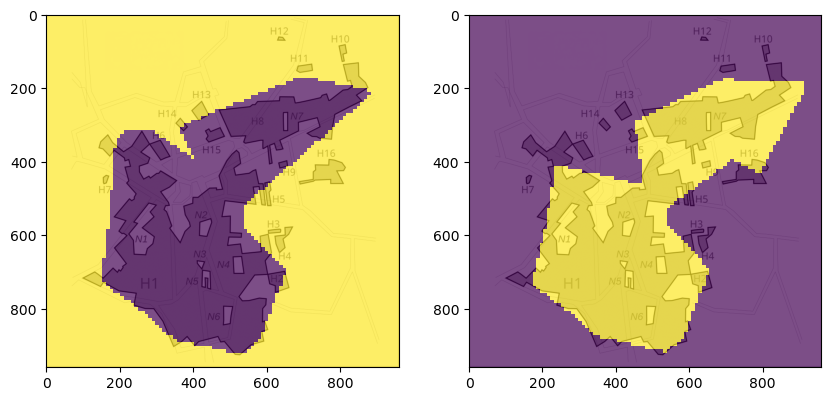

In [42]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [43]:
_=extract_weights_to_numpy(model)

import numpy as np

w1 = np.array([[-3.168, -0.803445],
 [3.42221, -1.78458],
 [0.617189, 1.08269],
 [-3.14148, 1.62554],
 [-2.88922, -2.88163],
 [-1.01818, -2.85778],
 [-0.52257, 2.85821],
 [-2.4109, 2.38119]], dtype=np.float32)
b1 = np.array([-1.51318, -2.0577, 0.566483, 0.35236, 0.0616211, -2.19501, -1.17172,
 0.782355], dtype=np.float32)
w2 = np.array([[3.6488, 12.0413, -0.358539, 2.1134, -1.70953, 9.39818, 4.55114,
  -1.80434],
 [-3.23387, -11.9316, 0.633187, -2.11428, 1.61074, -9.72797, -4.71059,
  1.38196]], dtype=np.float32)
b2 = np.array([0.693142, -0.677248], dtype=np.float32)


Ok nice - that's a pretty cool 8 neuron example -> i think minibatches are helping. 

## 16 Neurons

In [53]:
# random_seed = 36
num_neurons = 16
batch_size = 32  # Adjust batch size as needed

accuracies=[]
for random_seed in range(31, 64):
    torch.manual_seed(random_seed)  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Create dataset and dataloader for minibatching
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model and optimizer
    model = BaarleNet([num_neurons])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    num_epochs = 20
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        

    with torch.no_grad():
        outputs_batch = model(X_tensor)
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
    print(f'Random Seed [{random_seed}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Random Seed [31], Loss: 0.2448, Accuracy: 0.8643
Random Seed [32], Loss: 0.2448, Accuracy: 0.8669
Random Seed [33], Loss: 0.2448, Accuracy: 0.8702
Random Seed [34], Loss: 0.2448, Accuracy: 0.8623
Random Seed [35], Loss: 0.2448, Accuracy: 0.8730
Random Seed [36], Loss: 0.2448, Accuracy: 0.8690
Random Seed [37], Loss: 0.2448, Accuracy: 0.8610
Random Seed [38], Loss: 0.2448, Accuracy: 0.8860
Random Seed [39], Loss: 0.2448, Accuracy: 0.8710
Random Seed [40], Loss: 0.2448, Accuracy: 0.8528
Random Seed [41], Loss: 0.2448, Accuracy: 0.8659
Random Seed [42], Loss: 0.2448, Accuracy: 0.8587
Random Seed [43], Loss: 0.2448, Accuracy: 0.8711
Random Seed [44], Loss: 0.2448, Accuracy: 0.8796
Random Seed [45], Loss: 0.2448, Accuracy: 0.8603
Random Seed [46], Loss: 0.2448, Accuracy: 0.8699
Random Seed [47], Loss: 0.2448, Accuracy: 0.8730
Random Seed [48], Loss: 0.2448, Accuracy: 0.8738
Random Seed [49], Loss: 0.2448, Accuracy: 0.8678
Random Seed [50], Loss: 0.2448, Accuracy: 0.8797
Random Seed [51], Lo

In [55]:
random_seed = 55 #28
num_neurons = 16
batch_size = 32  # Adjust batch size as needed

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 160

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 25) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_tensor)
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [6/160], Loss: 0.3021, Accuracy: 0.8696
Epoch [12/160], Loss: 0.2891, Accuracy: 0.8732
Epoch [18/160], Loss: 0.2823, Accuracy: 0.8778
Epoch [24/160], Loss: 0.2799, Accuracy: 0.8844
Epoch [30/160], Loss: 0.2791, Accuracy: 0.8804
Epoch [36/160], Loss: 0.2784, Accuracy: 0.8842
Epoch [42/160], Loss: 0.2795, Accuracy: 0.8740
Epoch [48/160], Loss: 0.2783, Accuracy: 0.8834
Epoch [54/160], Loss: 0.2784, Accuracy: 0.8844
Epoch [60/160], Loss: 0.2790, Accuracy: 0.8818
Epoch [66/160], Loss: 0.2783, Accuracy: 0.8814
Epoch [72/160], Loss: 0.2790, Accuracy: 0.8838
Epoch [78/160], Loss: 0.2770, Accuracy: 0.8872
Epoch [84/160], Loss: 0.2738, Accuracy: 0.8763
Epoch [90/160], Loss: 0.2715, Accuracy: 0.8799
Epoch [96/160], Loss: 0.2705, Accuracy: 0.8843
Epoch [102/160], Loss: 0.2681, Accuracy: 0.8830
Epoch [108/160], Loss: 0.2653, Accuracy: 0.8875
Epoch [114/160], Loss: 0.2639, Accuracy: 0.8794
Epoch [120/160], Loss: 0.2629, Accuracy: 0.8933
Epoch [126/160], Loss: 0.2627, Accuracy: 0.8888
Epoch [13

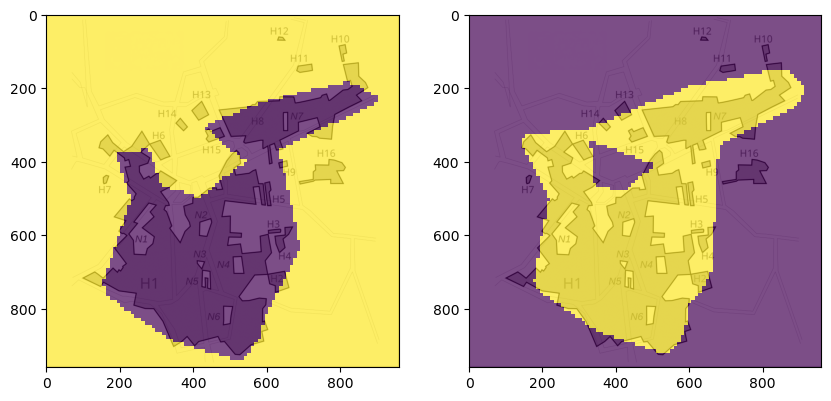

In [56]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

Ah dope - glad a tested more - an enclave!!

In [57]:
_=extract_weights_to_numpy(model)

import numpy as np

w1 = np.array([[-0.549905, 3.66561],
 [0.0530858, 2.09608],
 [2.60156, -0.957572],
 [-1.95678, 2.26806],
 [3.23673, -1.68136],
 [-4.12086, -2.45226],
 [1.47548, 1.33507],
 [-2.26969, 1.0313],
 [1.46112, -1.84614],
 [-0.151361, -0.264423],
 [-1.29911, 4.06289],
 [0.607951, 1.70711],
 [-0.157424, -0.244727],
 [-3.41311, -2.61467],
 [0.0385407, -0.152351],
 [-2.38861, 2.6493]], dtype=np.float32)
b1 = np.array([-1.39905, 1.10508, -0.0888145, -0.00702003, -1.98073, -0.595437, 1.91677,
 -1.19842, -0.00319139, -0.560146, -0.522038, 1.29003, -0.443363, -1.5144,
 -0.195263, 0.039926], dtype=np.float32)
w2 = np.array([[4.87542, 1.31792, 1.08728, 0.922798, 11.8357, -2.72542, -1.74628,
  3.74021, 0.573109, 0.195693, -3.10708, 1.21756, -0.102915, 4.42492,
  0.204624, 1.56483],
 [-4.4918, -1.11523, -1.07686, -0.72102, -11.714, 2.60495, 1.58645,
  -3.60151, -0.709827, -0.0891324, 3.23799, -1.17024, 0.0615712, -4.5723,
  0.0493513, -1.41648]], dtype=np.float32)
b2 = np.array([-0.29

## 32 Neurons

In [58]:
# random_seed = 36
num_neurons = 32
batch_size = 32  # Adjust batch size as needed

accuracies=[]
for random_seed in range(32):
    torch.manual_seed(random_seed)  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Create dataset and dataloader for minibatching
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model and optimizer
    model = BaarleNet([num_neurons])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    num_epochs = 20
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        

    with torch.no_grad():
        outputs_batch = model(X_tensor)
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
    print(f'Random Seed [{random_seed}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Random Seed [0], Loss: 0.2611, Accuracy: 0.8829
Random Seed [1], Loss: 0.2611, Accuracy: 0.8986
Random Seed [2], Loss: 0.2611, Accuracy: 0.8904
Random Seed [3], Loss: 0.2611, Accuracy: 0.8855
Random Seed [4], Loss: 0.2611, Accuracy: 0.8881
Random Seed [5], Loss: 0.2611, Accuracy: 0.8923
Random Seed [6], Loss: 0.2611, Accuracy: 0.8928
Random Seed [7], Loss: 0.2611, Accuracy: 0.8847
Random Seed [8], Loss: 0.2611, Accuracy: 0.8786
Random Seed [9], Loss: 0.2611, Accuracy: 0.8823
Random Seed [10], Loss: 0.2611, Accuracy: 0.8922
Random Seed [11], Loss: 0.2611, Accuracy: 0.8813
Random Seed [12], Loss: 0.2611, Accuracy: 0.8873
Random Seed [13], Loss: 0.2611, Accuracy: 0.8821
Random Seed [14], Loss: 0.2611, Accuracy: 0.8816
Random Seed [15], Loss: 0.2611, Accuracy: 0.8918
Random Seed [16], Loss: 0.2611, Accuracy: 0.8904
Random Seed [17], Loss: 0.2611, Accuracy: 0.8951
Random Seed [18], Loss: 0.2611, Accuracy: 0.8858
Random Seed [19], Loss: 0.2611, Accuracy: 0.8809
Random Seed [20], Loss: 0.2611

In [63]:
random_seed = 5 #31
num_neurons = 64
batch_size = 32  # Adjust batch size as needed

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 160

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 25) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_tensor)
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [6/160], Loss: 0.2885, Accuracy: 0.8710
Epoch [12/160], Loss: 0.2547, Accuracy: 0.8958
Epoch [18/160], Loss: 0.2468, Accuracy: 0.8925
Epoch [24/160], Loss: 0.2437, Accuracy: 0.8993
Epoch [30/160], Loss: 0.2405, Accuracy: 0.8973
Epoch [36/160], Loss: 0.2347, Accuracy: 0.9074
Epoch [42/160], Loss: 0.2314, Accuracy: 0.9122
Epoch [48/160], Loss: 0.2282, Accuracy: 0.9081
Epoch [54/160], Loss: 0.2277, Accuracy: 0.9003
Epoch [60/160], Loss: 0.2255, Accuracy: 0.9060
Epoch [66/160], Loss: 0.2258, Accuracy: 0.9041
Epoch [72/160], Loss: 0.2239, Accuracy: 0.9059
Epoch [78/160], Loss: 0.2210, Accuracy: 0.9118
Epoch [84/160], Loss: 0.2197, Accuracy: 0.9040
Epoch [90/160], Loss: 0.2173, Accuracy: 0.9119
Epoch [96/160], Loss: 0.2172, Accuracy: 0.9025
Epoch [102/160], Loss: 0.2160, Accuracy: 0.9082
Epoch [108/160], Loss: 0.2150, Accuracy: 0.9054
Epoch [114/160], Loss: 0.2154, Accuracy: 0.9108
Epoch [120/160], Loss: 0.2139, Accuracy: 0.9026
Epoch [126/160], Loss: 0.2138, Accuracy: 0.9092
Epoch [13

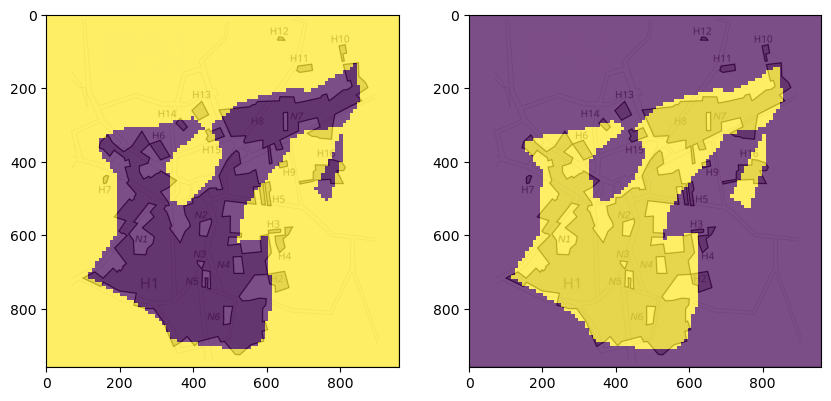

In [64]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [65]:
_=extract_weights_to_numpy(model, output_file='one_layer_32_nuerons.txt')

Weights saved to one_layer_32_nuerons.txt
import numpy as np

w1 = np.array([[2.63511, -2.52594],
 [-0.0985157, 0.105116],
 [2.13283, -2.67475],
 [-4.0555, 1.1106],
 [-3.74775, 1.08234],
 [0.150513, 0.0913175],
 [-0.0474001, 0.0639044],
 [0.271984, 0.0768487],
 [3.13227, -2.8852],
 [-3.05935, 1.74623],
 [0.00576526, -0.00660749],
 [-0.859551, 4.13822],
 [0.561059, -0.386188],
 [-2.53914, 1.66372],
 [-2.77364, -0.796165],
 [-2.75726, -0.63893],
 [-1.70987, -2.91514],
 [-1.07467, -2.99775],
 [0.143196, -2.13147],
 [-0.173345, -0.0659294],
 [-0.0589166, 0.0317942],
 [-1.94014, 2.42847],
 [-0.607166, 3.53761],
 [3.06299, -1.50923],
 [0.306546, -0.286027],
 [2.86277, -1.54383],
 [-2.23639, -1.40242],
 [2.68662, -0.163376],
 [2.86976, -0.56504],
 [-0.972202, 1.24646],
 [-2.54089, -1.57833],
 [-2.22228, -2.7733]], dtype=np.float32)
b1 = np.array([-1.37936, -0.176211, -0.183172, -0.167029, -0.756557, -0.458203,
 -0.115147, -0.386308, -1.11254, -0.824385, -0.0140904, -0.89294,
 -0.543161, -1.12

## 64 Neuron

In [67]:
# random_seed = 36
num_neurons = 64
batch_size = 32  # Adjust batch size as needed

accuracies=[]
for random_seed in range(31, 64):
    torch.manual_seed(random_seed)  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Create dataset and dataloader for minibatching
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model and optimizer
    model = BaarleNet([num_neurons])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    num_epochs = 20
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        

    with torch.no_grad():
        outputs_batch = model(X_tensor)
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
    print(f'Random Seed [{random_seed}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Random Seed [31], Loss: 0.2120, Accuracy: 0.8976
Random Seed [32], Loss: 0.2120, Accuracy: 0.9035
Random Seed [33], Loss: 0.2120, Accuracy: 0.8967
Random Seed [34], Loss: 0.2120, Accuracy: 0.9001
Random Seed [35], Loss: 0.2120, Accuracy: 0.8911
Random Seed [36], Loss: 0.2120, Accuracy: 0.9029
Random Seed [37], Loss: 0.2120, Accuracy: 0.8942
Random Seed [38], Loss: 0.2120, Accuracy: 0.8933
Random Seed [39], Loss: 0.2120, Accuracy: 0.8957
Random Seed [40], Loss: 0.2120, Accuracy: 0.8999
Random Seed [41], Loss: 0.2120, Accuracy: 0.8934
Random Seed [42], Loss: 0.2120, Accuracy: 0.8904
Random Seed [43], Loss: 0.2120, Accuracy: 0.8937
Random Seed [44], Loss: 0.2120, Accuracy: 0.8970
Random Seed [45], Loss: 0.2120, Accuracy: 0.8885
Random Seed [46], Loss: 0.2120, Accuracy: 0.8954
Random Seed [47], Loss: 0.2120, Accuracy: 0.9007
Random Seed [48], Loss: 0.2120, Accuracy: 0.8897
Random Seed [49], Loss: 0.2120, Accuracy: 0.8915
Random Seed [50], Loss: 0.2120, Accuracy: 0.8825
Random Seed [51], Lo

In [68]:
random_seed = 34 #31
num_neurons = 64
batch_size = 32  # Adjust batch size as needed

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 160

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 25) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_tensor)
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [6/160], Loss: 0.2778, Accuracy: 0.8793
Epoch [12/160], Loss: 0.2559, Accuracy: 0.8919
Epoch [18/160], Loss: 0.2428, Accuracy: 0.8983
Epoch [24/160], Loss: 0.2386, Accuracy: 0.9018
Epoch [30/160], Loss: 0.2358, Accuracy: 0.9002
Epoch [36/160], Loss: 0.2301, Accuracy: 0.9073
Epoch [42/160], Loss: 0.2263, Accuracy: 0.8972
Epoch [48/160], Loss: 0.2225, Accuracy: 0.9126
Epoch [54/160], Loss: 0.2193, Accuracy: 0.9118
Epoch [60/160], Loss: 0.2153, Accuracy: 0.9162
Epoch [66/160], Loss: 0.2149, Accuracy: 0.9165
Epoch [72/160], Loss: 0.2127, Accuracy: 0.9171
Epoch [78/160], Loss: 0.2098, Accuracy: 0.9156
Epoch [84/160], Loss: 0.2105, Accuracy: 0.9163
Epoch [90/160], Loss: 0.2093, Accuracy: 0.9145
Epoch [96/160], Loss: 0.2080, Accuracy: 0.9190
Epoch [102/160], Loss: 0.2080, Accuracy: 0.9179
Epoch [108/160], Loss: 0.2072, Accuracy: 0.9179
Epoch [114/160], Loss: 0.2080, Accuracy: 0.9141
Epoch [120/160], Loss: 0.2079, Accuracy: 0.9185
Epoch [126/160], Loss: 0.2058, Accuracy: 0.9097
Epoch [13

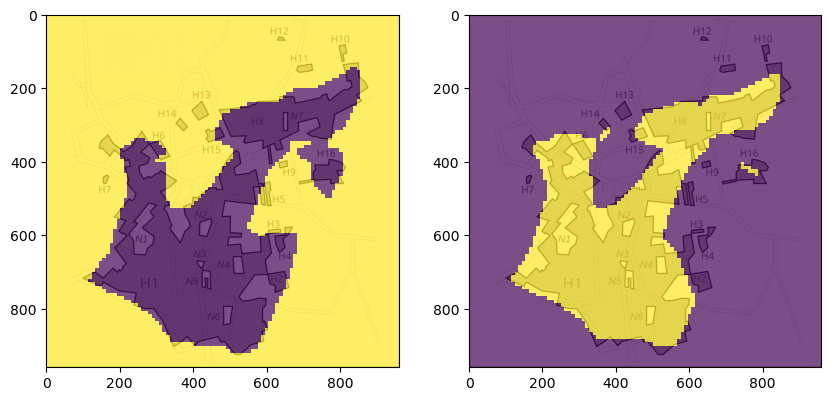

In [69]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [70]:
_=extract_weights_to_numpy(model, output_file='one_layer_64_nuerons.txt')

Weights saved to one_layer_64_nuerons.txt
import numpy as np

w1 = np.array([[0.0324239, -0.0407275],
 [0.131026, -0.102662],
 [2.26495, -2.23179],
 [-0.0881913, 0.0892285],
 [-0.576089, 2.69701],
 [0.314549, 0.873783],
 [-3.41664, 1.44898],
 [-0.00920205, 0.00890138],
 [-0.00607428, -0.00753802],
 [-2.25916, -1.80586],
 [-0.0610635, 0.00673501],
 [-2.037, -1.2062],
 [0.0396965, -0.487327],
 [4.77268, 1.08767],
 [-0.652608, 3.25208],
 [0.122895, -0.14724],
 [0.00338457, -0.0275793],
 [-2.30854, -1.37174],
 [-0.129665, 0.0909221],
 [0.0766278, -0.122342],
 [3.45518, -1.24316],
 [2.56092, -1.05567],
 [-0.00418197, 0.00353178],
 [5.61657e-05, -0.0233762],
 [2.7088, -1.28499],
 [2.84564, -1.34958],
 [1.37078, -1.56298],
 [-2.24622, 0.309784],
 [-0.977824, 3.1931],
 [-3.22315, 2.03793],
 [0.0159078, -0.00905866],
 [0.119475, -0.135782],
 [1.86599, -1.84405],
 [0.00303979, -0.00430246],
 [-2.13335, -1.27567],
 [2.25361, -1.70531],
 [-1.89286, 2.23354],
 [-0.0980731, 0.0565795],
 [-0.116673, 

## 128

In [71]:
# random_seed = 36
num_neurons = 128
batch_size = 32  # Adjust batch size as needed

accuracies=[]
for random_seed in range(31, 64):
    torch.manual_seed(random_seed)  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Create dataset and dataloader for minibatching
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model and optimizer
    model = BaarleNet([num_neurons])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    num_epochs = 20
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        

    with torch.no_grad():
        outputs_batch = model(X_tensor)
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
    print(f'Random Seed [{random_seed}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Random Seed [31], Loss: 0.2025, Accuracy: 0.8994
Random Seed [32], Loss: 0.2025, Accuracy: 0.9012
Random Seed [33], Loss: 0.2025, Accuracy: 0.9009
Random Seed [34], Loss: 0.2025, Accuracy: 0.9010
Random Seed [35], Loss: 0.2025, Accuracy: 0.9022
Random Seed [36], Loss: 0.2025, Accuracy: 0.9021
Random Seed [37], Loss: 0.2025, Accuracy: 0.9049
Random Seed [38], Loss: 0.2025, Accuracy: 0.9084
Random Seed [39], Loss: 0.2025, Accuracy: 0.9058
Random Seed [40], Loss: 0.2025, Accuracy: 0.8992
Random Seed [41], Loss: 0.2025, Accuracy: 0.8931
Random Seed [42], Loss: 0.2025, Accuracy: 0.8998
Random Seed [43], Loss: 0.2025, Accuracy: 0.9007
Random Seed [44], Loss: 0.2025, Accuracy: 0.9036
Random Seed [45], Loss: 0.2025, Accuracy: 0.8990
Random Seed [46], Loss: 0.2025, Accuracy: 0.9080
Random Seed [47], Loss: 0.2025, Accuracy: 0.9064
Random Seed [48], Loss: 0.2025, Accuracy: 0.9025
Random Seed [49], Loss: 0.2025, Accuracy: 0.9082
Random Seed [50], Loss: 0.2025, Accuracy: 0.9038
Random Seed [51], Lo

In [72]:
random_seed = 58 #31
num_neurons = 128
batch_size = 32  # Adjust batch size as needed

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 160

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 25) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_tensor)
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [6/160], Loss: 0.2558, Accuracy: 0.8682
Epoch [12/160], Loss: 0.2359, Accuracy: 0.9016
Epoch [18/160], Loss: 0.2288, Accuracy: 0.9040
Epoch [24/160], Loss: 0.2216, Accuracy: 0.9032
Epoch [30/160], Loss: 0.2168, Accuracy: 0.9147
Epoch [36/160], Loss: 0.2136, Accuracy: 0.9094
Epoch [42/160], Loss: 0.2143, Accuracy: 0.9141
Epoch [48/160], Loss: 0.2109, Accuracy: 0.9194
Epoch [54/160], Loss: 0.2090, Accuracy: 0.9163
Epoch [60/160], Loss: 0.2089, Accuracy: 0.9043
Epoch [66/160], Loss: 0.2056, Accuracy: 0.9171
Epoch [72/160], Loss: 0.2026, Accuracy: 0.9147
Epoch [78/160], Loss: 0.2033, Accuracy: 0.9154
Epoch [84/160], Loss: 0.2009, Accuracy: 0.9190
Epoch [90/160], Loss: 0.1975, Accuracy: 0.9152
Epoch [96/160], Loss: 0.1969, Accuracy: 0.9185
Epoch [102/160], Loss: 0.1961, Accuracy: 0.9254
Epoch [108/160], Loss: 0.1939, Accuracy: 0.9216
Epoch [114/160], Loss: 0.1914, Accuracy: 0.9022
Epoch [120/160], Loss: 0.1932, Accuracy: 0.9226
Epoch [126/160], Loss: 0.1895, Accuracy: 0.9241
Epoch [13

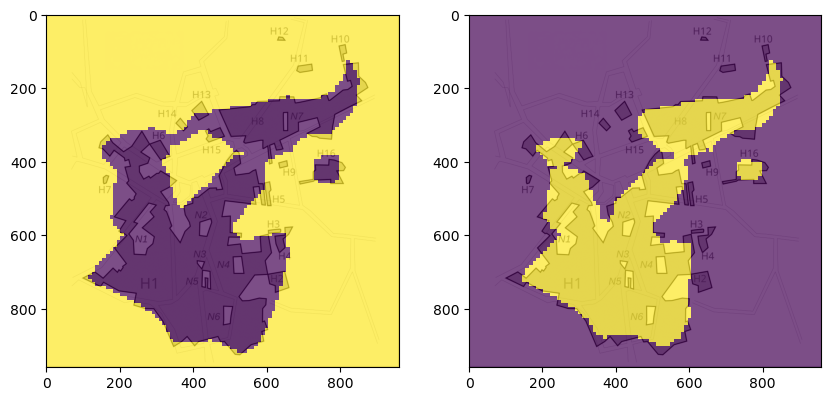

In [73]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [74]:
_=extract_weights_to_numpy(model, output_file='one_layer_128_nuerons.txt')

Weights saved to one_layer_128_nuerons.txt
import numpy as np

w1 = np.array([[-3.28463, -0.703866],
 [0.0123237, -0.439954],
 [-0.0191408, 0.00671681],
 [0.368222, -2.91813],
 [-0.651556, 2.61427],
 [-1.50697, 1.8529],
 [-3.53313, 1.20409],
 [2.38077, -0.713831],
 [0.0432241, -0.0092818],
 [-2.81215, 1.51007],
 [1.68272, 3.05422],
 [-0.00666971, -0.00161218],
 [-0.0110836, 0.0130226],
 [-3.11311, -0.180478],
 [0.233081, -0.0628893],
 [2.38064, -1.11591],
 [-1.0486, -0.92822],
 [1.19399, 2.99268],
 [0.0019716, -0.00380982],
 [1.96722, 1.2005],
 [-1.83467, -1.52505],
 [-2.02734, -1.0776],
 [-0.104624, -0.0870938],
 [0.358788, -0.271851],
 [-0.596176, 2.89539],
 [-0.0176224, -0.00269578],
 [0.0208109, 0.0647418],
 [-0.123767, -0.0889759],
 [-1.00975, 1.54906],
 [0.894026, -3.57467],
 [-0.783589, 1.02577],
 [0.0147924, -0.00578446],
 [-3.20737, 1.02368],
 [-2.07965, -1.25657],
 [0.0352866, -0.0258242],
 [-0.144749, 2.46755],
 [-2.77703, 0.918935],
 [0.336225, -3.81666],
 [2.60432, -0.6780

## 256

In [75]:
# random_seed = 36
num_neurons = 256
batch_size = 32  # Adjust batch size as needed

accuracies=[]
for random_seed in range(10):
    torch.manual_seed(random_seed)  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Create dataset and dataloader for minibatching
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model and optimizer
    model = BaarleNet([num_neurons])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    num_epochs = 20
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        

    with torch.no_grad():
        outputs_batch = model(X_tensor)
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
    print(f'Random Seed [{random_seed}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Random Seed [0], Loss: 0.1854, Accuracy: 0.9005
Random Seed [1], Loss: 0.1854, Accuracy: 0.9103
Random Seed [2], Loss: 0.1854, Accuracy: 0.9052
Random Seed [3], Loss: 0.1854, Accuracy: 0.9084
Random Seed [4], Loss: 0.1854, Accuracy: 0.9056
Random Seed [5], Loss: 0.1854, Accuracy: 0.9057
Random Seed [6], Loss: 0.1854, Accuracy: 0.9063
Random Seed [7], Loss: 0.1854, Accuracy: 0.8978
Random Seed [8], Loss: 0.1854, Accuracy: 0.9098
Random Seed [9], Loss: 0.1854, Accuracy: 0.9120


In [76]:
random_seed = 9 #31
num_neurons = 256
batch_size = 32  # Adjust batch size as needed

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 160

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 25) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_tensor)
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [6/160], Loss: 0.2509, Accuracy: 0.8908
Epoch [12/160], Loss: 0.2344, Accuracy: 0.9129
Epoch [18/160], Loss: 0.2255, Accuracy: 0.9066
Epoch [24/160], Loss: 0.2224, Accuracy: 0.9141
Epoch [30/160], Loss: 0.2151, Accuracy: 0.9087
Epoch [36/160], Loss: 0.2126, Accuracy: 0.9173
Epoch [42/160], Loss: 0.2085, Accuracy: 0.9182
Epoch [48/160], Loss: 0.2124, Accuracy: 0.9112
Epoch [54/160], Loss: 0.2059, Accuracy: 0.9067
Epoch [60/160], Loss: 0.2036, Accuracy: 0.9200
Epoch [66/160], Loss: 0.2037, Accuracy: 0.9166
Epoch [72/160], Loss: 0.2056, Accuracy: 0.9194
Epoch [78/160], Loss: 0.1977, Accuracy: 0.9177
Epoch [84/160], Loss: 0.1986, Accuracy: 0.9181
Epoch [90/160], Loss: 0.1981, Accuracy: 0.9205
Epoch [96/160], Loss: 0.1981, Accuracy: 0.9200
Epoch [102/160], Loss: 0.1926, Accuracy: 0.9174
Epoch [108/160], Loss: 0.1926, Accuracy: 0.9212
Epoch [114/160], Loss: 0.1915, Accuracy: 0.9220
Epoch [120/160], Loss: 0.1895, Accuracy: 0.9285
Epoch [126/160], Loss: 0.1882, Accuracy: 0.9236
Epoch [13

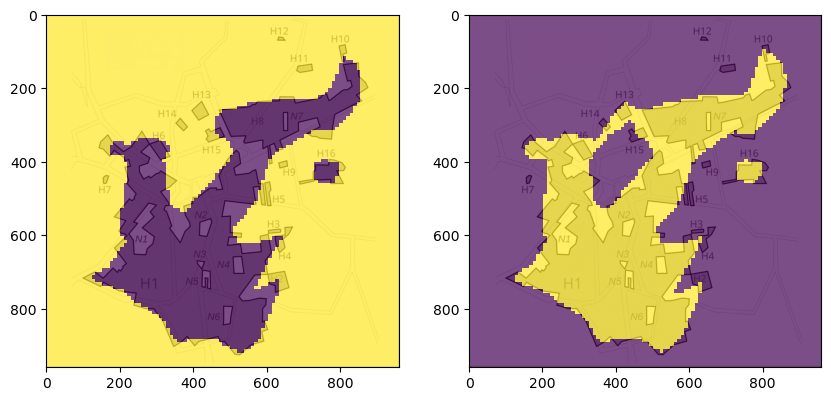

In [77]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [78]:
_=extract_weights_to_numpy(model, output_file='one_layer_256_nuerons.txt')

Weights saved to one_layer_256_nuerons.txt
import numpy as np

w1 = np.array([[0.190654, -0.124296],
 [-0.161781, 2.55647],
 [0.011838, 0.0283251],
 [-0.634575, 2.81258],
 [0.137236, -0.136524],
 [2.41258, -0.56209],
 [-2.23429, -1.26518],
 [0.133355, -0.128629],
 [0.00594916, -0.0021546],
 [-0.103635, -0.0157975],
 [0.0406442, 0.134945],
 [2.5315, -0.3334],
 [-0.951586, -1.93495],
 [1.87932, 1.17475],
 [0.0141588, -0.00121914],
 [0.178918, 0.238772],
 [0.00394944, 0.0257677],
 [0.319805, -0.132042],
 [-1.87961, 0.591659],
 [2.35897, -2.38474],
 [2.47585, -0.607914],
 [0.390748, 0.150819],
 [-1.31073, 1.63666],
 [-0.19843, 0.4804],
 [0.142074, -0.115431],
 [2.52961, -0.892714],
 [-0.00327946, 0.0345236],
 [-0.228115, -0.786765],
 [0.725912, -2.96906],
 [0.00330212, 0.0213013],
 [-0.0391268, 0.030961],
 [-0.398311, 3.33236],
 [0.488464, -3.65184],
 [-0.00187832, -0.105449],
 [-1.34173, 2.14967],
 [-0.0215891, -0.0469788],
 [-0.0513846, 0.0960117],
 [0.0262986, 0.0351433],
 [0.178734, -0

## 512

In [79]:
# random_seed = 36
num_neurons = 512
batch_size = 32  # Adjust batch size as needed

accuracies=[]
for random_seed in range(10):
    torch.manual_seed(random_seed)  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Create dataset and dataloader for minibatching
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model and optimizer
    model = BaarleNet([num_neurons])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    num_epochs = 20
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        

    with torch.no_grad():
        outputs_batch = model(X_tensor)
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
    print(f'Random Seed [{random_seed}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Random Seed [0], Loss: 0.1807, Accuracy: 0.9107
Random Seed [1], Loss: 0.1807, Accuracy: 0.9074
Random Seed [2], Loss: 0.1807, Accuracy: 0.9126
Random Seed [3], Loss: 0.1807, Accuracy: 0.9109
Random Seed [4], Loss: 0.1807, Accuracy: 0.8984
Random Seed [5], Loss: 0.1807, Accuracy: 0.9066
Random Seed [6], Loss: 0.1807, Accuracy: 0.9176
Random Seed [7], Loss: 0.1807, Accuracy: 0.9059
Random Seed [8], Loss: 0.1807, Accuracy: 0.9059
Random Seed [9], Loss: 0.1807, Accuracy: 0.9076


In [81]:
random_seed = 3 #31
num_neurons = 512
batch_size = 32  # Adjust batch size as needed

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)
num_epochs = 250

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 25) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_tensor)
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/250], Loss: 0.2374, Accuracy: 0.8921
Epoch [20/250], Loss: 0.2181, Accuracy: 0.9074
Epoch [30/250], Loss: 0.2103, Accuracy: 0.9122
Epoch [40/250], Loss: 0.2021, Accuracy: 0.9093
Epoch [50/250], Loss: 0.1976, Accuracy: 0.9240
Epoch [60/250], Loss: 0.1947, Accuracy: 0.9251
Epoch [70/250], Loss: 0.1932, Accuracy: 0.9256
Epoch [80/250], Loss: 0.1898, Accuracy: 0.9259
Epoch [90/250], Loss: 0.1839, Accuracy: 0.9157
Epoch [100/250], Loss: 0.1802, Accuracy: 0.9237
Epoch [110/250], Loss: 0.1813, Accuracy: 0.9292
Epoch [120/250], Loss: 0.1760, Accuracy: 0.9302
Epoch [130/250], Loss: 0.1743, Accuracy: 0.9365
Epoch [140/250], Loss: 0.1705, Accuracy: 0.9366
Epoch [150/250], Loss: 0.1677, Accuracy: 0.9358
Epoch [160/250], Loss: 0.1709, Accuracy: 0.9276
Epoch [170/250], Loss: 0.1666, Accuracy: 0.9353
Epoch [180/250], Loss: 0.1659, Accuracy: 0.9334
Epoch [190/250], Loss: 0.1629, Accuracy: 0.9345
Epoch [200/250], Loss: 0.1649, Accuracy: 0.9343
Epoch [210/250], Loss: 0.1625, Accuracy: 0.9458
E

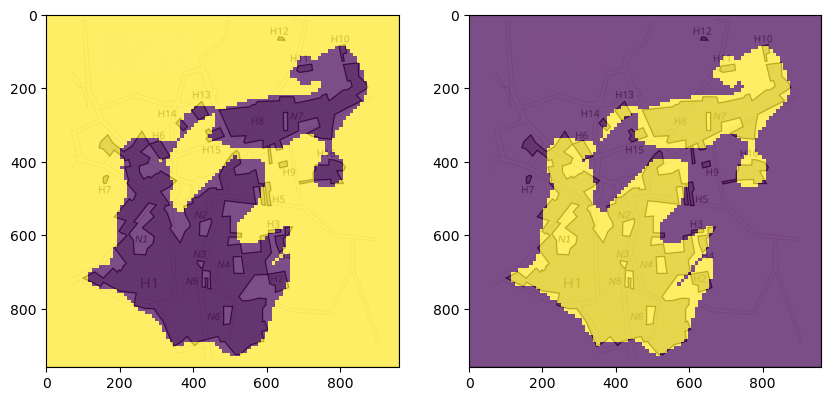

In [82]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [83]:
_=extract_weights_to_numpy(model, output_file='one_layer_512_nuerons.py')

Weights saved to one_layer_512_nuerons.py
import numpy as np

w1 = np.array([[-1.57269, -0.779502],
 [0.000747681, -0.000562905],
 [-1.21993, -1.56512],
 ...,
 [2.48103, -1.07652],
 [0.144572, -0.166943],
 [0.16065, -0.311042]], dtype=np.float32)
b1 = np.array([-1.12156, -0.00132431, -1.70591, -0.858895, -0.738472, -0.663005,
 -0.133441, -0.0317366, -0.118712, -0.0272513, -0.0688314, -0.353357,
 -1.62442, -0.21064, -0.220131, -0.905833, -1.07391, -0.740993, -0.563204,
 -0.218898, -0.499509, -0.472878, -0.249948, -0.0201532, -0.894293,
 -0.705557, -0.0416291, -0.00801304, -1.05536, -1.48645, -0.541504,
 -1.42866, -0.196674, -0.529254, -0.419988, -0.0359844, -0.0784522,
 -0.672576, -0.0559575, -0.277345, -0.0236165, -0.819289, -0.331431,
 -0.0664388, -0.786787, -0.235571, -0.149862, -0.0644367, -0.325577,
 -1.15597, -0.452817, -0.0394298, -0.137146, -1.34392, -0.0729788,
 -0.671683, -1.65009, -1.34041, -0.0245769, -0.618915, -1.02955,
 -0.0889728, -0.992925, -0.591988, -0.0295034, -1.052

## 1024

In [84]:
# random_seed = 36
num_neurons = 1024
batch_size = 32  # Adjust batch size as needed

accuracies=[]
for random_seed in range(10):
    torch.manual_seed(random_seed)  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Create dataset and dataloader for minibatching
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model and optimizer
    model = BaarleNet([num_neurons])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0035)
    num_epochs = 20
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        

    with torch.no_grad():
        outputs_batch = model(X_tensor)
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
    print(f'Random Seed [{random_seed}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Random Seed [0], Loss: 0.1565, Accuracy: 0.9082
Random Seed [1], Loss: 0.1565, Accuracy: 0.9095
Random Seed [2], Loss: 0.1565, Accuracy: 0.9095
Random Seed [3], Loss: 0.1565, Accuracy: 0.8924
Random Seed [4], Loss: 0.1565, Accuracy: 0.9039
Random Seed [5], Loss: 0.1565, Accuracy: 0.9174
Random Seed [6], Loss: 0.1565, Accuracy: 0.9109
Random Seed [7], Loss: 0.1565, Accuracy: 0.9152
Random Seed [8], Loss: 0.1565, Accuracy: 0.9051
Random Seed [9], Loss: 0.1565, Accuracy: 0.9141


In [93]:
random_seed = 7 #31
num_neurons = 1024
batch_size = 32  # Adjust batch size as needed

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0035)
num_epochs = 250

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 25) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_tensor)
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/250], Loss: 0.2307, Accuracy: 0.8998
Epoch [20/250], Loss: 0.2107, Accuracy: 0.9152
Epoch [30/250], Loss: 0.2038, Accuracy: 0.9206
Epoch [40/250], Loss: 0.1969, Accuracy: 0.9215
Epoch [50/250], Loss: 0.1909, Accuracy: 0.9218
Epoch [60/250], Loss: 0.1859, Accuracy: 0.9256
Epoch [70/250], Loss: 0.1768, Accuracy: 0.9289
Epoch [80/250], Loss: 0.1773, Accuracy: 0.9247
Epoch [90/250], Loss: 0.1756, Accuracy: 0.9208
Epoch [100/250], Loss: 0.1688, Accuracy: 0.9236
Epoch [110/250], Loss: 0.1686, Accuracy: 0.9348
Epoch [120/250], Loss: 0.1652, Accuracy: 0.9169
Epoch [130/250], Loss: 0.1671, Accuracy: 0.9356
Epoch [140/250], Loss: 0.1674, Accuracy: 0.9427
Epoch [150/250], Loss: 0.1656, Accuracy: 0.9242
Epoch [160/250], Loss: 0.1635, Accuracy: 0.9388
Epoch [170/250], Loss: 0.1586, Accuracy: 0.9310
Epoch [180/250], Loss: 0.1599, Accuracy: 0.9378
Epoch [190/250], Loss: 0.1587, Accuracy: 0.9365
Epoch [200/250], Loss: 0.1561, Accuracy: 0.9319
Epoch [210/250], Loss: 0.1598, Accuracy: 0.9388
E

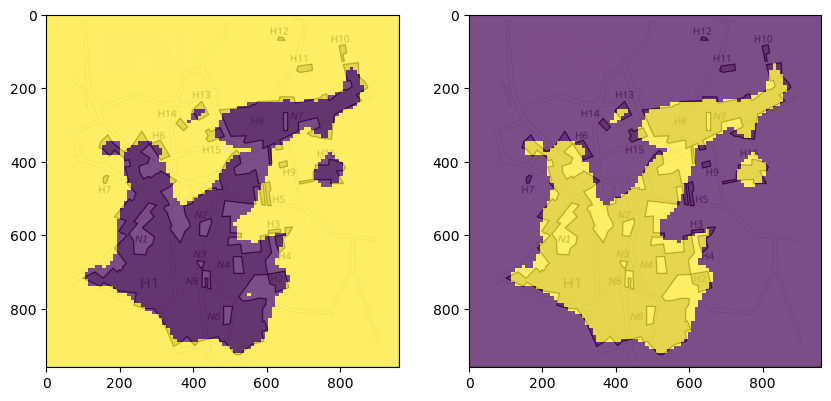

In [94]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [95]:
_=extract_weights_to_numpy(model, output_file='one_layer_1024_nuerons.py')

Weights saved to one_layer_512_nuerons.py
import numpy as np

w1 = np.array([[1.44188, -1.42798],
 [0.0156165, 0.00892964],
 [0.0445411, -0.0706409],
 ...,
 [-0.295166, -0.810518],
 [-0.263908, 0.0181089],
 [-0.0444839, 0.0462433]], dtype=np.float32)
b1 = np.array([-0.554086, -0.0271071, -0.155944, ..., -1.00824, -0.311047, -0.0588725], dtype=np.float32)
w2 = np.array([[-0.378442, -0.00687345, -0.117286, ..., -0.0395821, 0.0174087,
  -0.00703656],
 [0.429611, -0.00445609, 0.0916964, ..., 0.0614532, -0.00669834,
  -0.00496637]], dtype=np.float32)
b2 = np.array([-0.149542, 0.175614], dtype=np.float32)


In [96]:
torch.save(model,  'one_layer_1024_nuerons.pt')

## ALOT

In [ ]:
# # random_seed = 36
# num_neurons = 10000
# batch_size = 32  # Adjust batch size as needed

# accuracies=[]
# for random_seed in range(31, 64):
#     torch.manual_seed(random_seed)  
#     X_tensor = torch.FloatTensor(X)
#     y_tensor = torch.tensor(y)
    
#     # Create dataset and dataloader for minibatching
#     dataset = TensorDataset(X_tensor, y_tensor)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
#     # Initialize model and optimizer
#     model = BaarleNet([num_neurons])
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.005)
#     num_epochs = 20
    
#     for epoch in range(num_epochs):
#         epoch_loss = 0.0
#         num_batches = 0
        
#         for batch_X, batch_y in dataloader:
#             # Forward pass
#             outputs = model(batch_X)
#             loss = criterion(outputs, batch_y)
            
#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             epoch_loss += loss.item()
#             num_batches += 1
        

#     with torch.no_grad():
#         outputs_batch = model(X_tensor)
#         accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
#     print(f'Random Seed [{random_seed}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

In [88]:
random_seed = 55 #31
num_neurons = 10000
batch_size = 32  # Adjust batch size as needed

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
num_epochs = 500

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 25) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_tensor)
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [20/500], Loss: 0.1943, Accuracy: 0.8887
Epoch [40/500], Loss: 0.1774, Accuracy: 0.9328
Epoch [60/500], Loss: 0.1809, Accuracy: 0.9284
Epoch [80/500], Loss: 0.1652, Accuracy: 0.9358
Epoch [100/500], Loss: 0.1647, Accuracy: 0.9416
Epoch [120/500], Loss: 0.1574, Accuracy: 0.9392
Epoch [140/500], Loss: 0.1595, Accuracy: 0.9187
Epoch [160/500], Loss: 0.1555, Accuracy: 0.9423
Epoch [180/500], Loss: 0.1520, Accuracy: 0.9472
Epoch [200/500], Loss: 0.1507, Accuracy: 0.9456
Epoch [220/500], Loss: 0.1510, Accuracy: 0.9445
Epoch [240/500], Loss: 0.1484, Accuracy: 0.9496
Epoch [260/500], Loss: 0.1454, Accuracy: 0.9406
Epoch [280/500], Loss: 0.1419, Accuracy: 0.9506
Epoch [300/500], Loss: 0.1420, Accuracy: 0.9486
Epoch [320/500], Loss: 0.1470, Accuracy: 0.9217
Epoch [340/500], Loss: 0.1394, Accuracy: 0.9371
Epoch [360/500], Loss: 0.1394, Accuracy: 0.9540
Epoch [380/500], Loss: 0.1368, Accuracy: 0.9553
Epoch [400/500], Loss: 0.1313, Accuracy: 0.9472
Epoch [420/500], Loss: 0.1336, Accuracy: 0.9

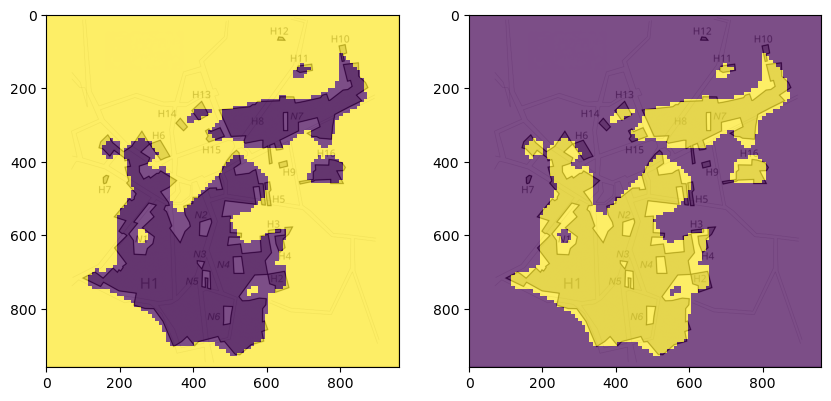

In [89]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [90]:
_=extract_weights_to_numpy(model, output_file='one_layer_alot_nuerons.py')

Weights saved to one_layer_alot_nuerons.py
import numpy as np

w1 = np.array([[-0.0238195, 0.0583468],
 [0.301074, -0.0564573],
 [0.267305, -0.0804741],
 ...,
 [0.0692362, 0.0809731],
 [-0.46771, 0.763986],
 [-0.198104, -0.101505]], dtype=np.float32)
b1 = np.array([-0.0528064, -0.251373, -0.206037, ..., -0.145489, -0.754661, -0.485764], dtype=np.float32)
w2 = np.array([[0.00535626, 0.0220983, 0.00455496, ..., 0.0258963, -0.00587285,
  0.00760061],
 [0.00505464, -0.0257472, 0.00102399, ..., -0.0292187, 0.00124508,
  0.00192303]], dtype=np.float32)
b2 = np.array([-1.37107, 1.35625], dtype=np.float32)


In [92]:
torch.save(model,  'one_layer_10k_neurons.pt')